# PROJECT PIPELINE: MACHINE LEARNING–BASED ANALYSIS AND COMPARISON OF SPECIFIC CAPACITANCE FROM CV AND GCD

## 1. ENVIRONMENT SETUP AND DEPENDENCIES

### 1.1 VIRTUAL ENVIRONMENT PACKAGES (REQUIREMENTS.TXT)

THE FOLLOWING PACKAGES MUST BE INSTALLED IN YOUR VENV TO RUN THIS PIPELINE:

- PANDAS>=1.5.0
- NUMPY>=1.23.0
- MATPLOTLIB>=3.6.0
- SEABORN>=0.12.0
- SCIKIT-LEARN>=1.2.0
- XGBOOST>=1.7.0
- LIGHTGBM>=3.3.0
- SHAP>=0.41.0
- SCIPY>=1.9.0

### 1.2 GLOBAL IMPORTS AND VISUALIZATION STANDARDS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
# -----------------------------------------------------------------------------
# GLOBAL VISUALIZATION STANDARDS
# -----------------------------------------------------------------------------
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.dpi': 500,
    'axes.grid': True,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 12
})

## 2. DATA LOADING AND VALIDATION

### 2.1 LOAD DATASETS, CLEAN UNNAMED COLUMNS, AND DISPLAY SHAPE

In [4]:
def load_and_clean_data(cv_path: str, gcd_path: str) -> tuple:
    """
    LOADS CV AND GCD DATASETS, REMOVES UNNAMED COLUMNS,
    AND DISPLAYS BASIC SHAPE AND HEAD INFO.
    
    PARAMETERS:
    - cv_path: STRING PATH TO CV CSV
    - gcd_path: STRING PATH TO GCD CSV
    
    RETURNS:
    - TUPLE OF (CV_DATAFRAME, GCD_DATAFRAME)
    """
    cv_df = pd.read_csv(cv_path)
    gcd_df = pd.read_csv(gcd_path)
    
    # DROP UNNAMED COLUMNS IN CV DATA
    cv_df = cv_df.loc[:, ~cv_df.columns.str.contains('^Unnamed')]
    
    print("=== CV DATASET SHAPE ===")
    print(cv_df.shape)
    print("\n=== CV DATASET HEAD ===")
    display(cv_df.head())
    
    print("\n=== GCD DATASET SHAPE ===")
    print(gcd_df.shape)
    print("\n=== GCD DATASET HEAD ===")
    display(gcd_df.head())
    
    return cv_df, gcd_df

# EXECUTE DATA LOADING
cv_df, gcd_df = load_and_clean_data(
    '../DATASET/DATA/AL203-1M-KOH-CV.csv',
    '../DATASET/DATA/AL203-1M-KOH-GCD.csv'
)

=== CV DATASET SHAPE ===
(8752, 5)

=== CV DATASET HEAD ===


,Scan_Rate,Potential,Current,Area,CS
0,100,-0.29984,-0.51050,2.41787,60.44685
1,100,-0.29885,-0.41119,2.41787,60.44685
2,100,-0.29786,-0.34692,2.41787,60.44685
3,100,-0.29380,-0.19546,2.41787,60.44685
4,100,-0.29284,-0.17072,2.41787,60.44685



=== GCD DATASET SHAPE ===
(3944, 5)

=== GCD DATASET HEAD ===


,Current_Density,Time,Potential,Discharge_Time,GCD_CS
0,5.0,-3.170000e-07,-0.15928,2.88868,36.1085
1,5.0,1.000000e-01,-0.08898,2.88868,36.1085
2,5.0,2.000000e-01,-0.07416,2.88868,36.1085
3,5.0,3.000000e-01,-0.06734,2.88868,36.1085
4,5.0,4.000000e-01,-0.06165,2.88868,36.1085


### 2.2 VALIDATE MISSING VALUES, DUPLICATES, AND CS RANGE

In [5]:
def validate_data(df: pd.DataFrame, dataset_name: str, target_col: str):
    """
    CHECKS FOR MISSING VALUES, DUPLICATES, OUTLIERS, 
    AND VALIDATES TARGET VARIABLE (Cs) RANGE.
    """
    print(f"\n{'='*40}")
    print(f"DATA VALIDATION: {dataset_name.upper()}")
    print(f"{'='*40}")
    
    # MISSING VALUES
    missing_count = df.isnull().sum().sum()
    print(f"TOTAL MISSING VALUES: {missing_count}")
    
    # DUPLICATES
    duplicate_count = df.duplicated().sum()
    print(f"TOTAL DUPLICATE ROWS: {duplicate_count}")
    
    # VALIDATE CS (SPECIFIC CAPACITANCE)
    if target_col in df.columns:
        print(f"\n{target_col.upper()} (TARGET) SUMMARY STATISTICS:")
        display(df[target_col].describe())
        
        # OUTLIER DETECTION VIA Z-SCORE
        z_scores = np.abs(stats.zscore(df[target_col].dropna()))
        outliers = np.where(z_scores > 3)[0]
        print(f"DETECTED OUTLIERS IN {target_col.upper()} (Z > 3): {len(outliers)}")
    else:
        print(f"TARGET COLUMN '{target_col}' NOT FOUND.")

validate_data(cv_df, "CV Dataset", "CS")
validate_data(gcd_df, "GCD Dataset", "GCD_CS")


DATA VALIDATION: CV DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

CS (TARGET) SUMMARY STATISTICS:


count    8752.000000
mean       71.759403
std         7.996925
min        60.446850
25%        64.487200
50%        70.618030
75%        78.711160
max        86.419420
Name: CS, dtype: float64

DETECTED OUTLIERS IN CS (Z > 3): 0

DATA VALIDATION: GCD DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

GCD_CS (TARGET) SUMMARY STATISTICS:


count    3944.000000
mean       45.440003
std         3.206760
min        36.108500
25%        44.553500
50%        46.711120
75%        47.745620
max        47.745620
Name: GCD_CS, dtype: float64

DETECTED OUTLIERS IN GCD_CS (Z > 3): 0


## 3. FEATURE ENGINEERING AND MERGING

### 3.1 STANDARDIZE COLUMNS AND DERIVE ELECTROCHEMICAL FEATURES

In [6]:
def engineer_features(cv_df: pd.DataFrame, gcd_df: pd.DataFrame) -> pd.DataFrame:
    """
    STANDARDIZES COLUMN NAMES, CREATES METHOD FLAGS, 
    DERIVES NEW ELECTROCHEMICAL FEATURES, AND MERGES BOTH DATASETS.
    """
    # 1. RENAME TARGET AND COMMON COLUMNS
    cv_clean = cv_df.rename(columns={'CS': 'Cs'})
    gcd_clean = gcd_df.rename(columns={'GCD_CS': 'Cs'})
    
    # 2. METHOD FLAGS
    cv_clean['Method'] = 'CV'
    gcd_clean['Method'] = 'GCD'
    
    # 3. DERIVE CURRENT DENSITY FOR CV
    # A = Area, I = Current
    # Current Density (A/g or A/cm2) = I / A
    cv_clean['Current_Density'] = cv_clean['Current'] / cv_clean['Area']
    
    # 4. POTENTIAL WINDOW CALCULATION
    cv_clean['Potential_Window'] = cv_clean.groupby('Scan_Rate')['Potential'].transform(lambda x: x.max() - x.min())
    gcd_clean['Potential_Window'] = gcd_clean.groupby('Current_Density')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 5. MERGE DATASETS
    # WE CONCATENATE THE COMMON COLUMNS FOR CROSS-METHOD ANALYSIS
    common_cols = ['Potential', 'Current_Density', 'Cs', 'Method', 'Potential_Window']
    
    # KEEPING DOMAIN SPECIFIC COLUMNS PADDED WITH NAN
    unified_df = pd.concat([cv_clean, gcd_clean], ignore_index=True)
    
    print("=== UNIFIED DATASET SHAPE ===")
    print(unified_df.shape)
    
    return unified_df, cv_clean, gcd_clean

unified_df, cv_clean, gcd_clean = engineer_features(cv_df, gcd_df)

=== UNIFIED DATASET SHAPE ===
(12696, 10)


In [7]:
unified_df

,Scan_Rate,Potential,Current,Area,Cs,Method,Current_Density,Potential_Window,Time,Discharge_Time
0,100.0,-0.29984,-0.51050,2.41787,60.44685,CV,-0.211136,0.40035,NaN,NaN
1,100.0,-0.29885,-0.41119,2.41787,60.44685,CV,-0.170063,0.40035,NaN,NaN
2,100.0,-0.29786,-0.34692,2.41787,60.44685,CV,-0.143482,0.40035,NaN,NaN
3,100.0,-0.29380,-0.19546,2.41787,60.44685,CV,-0.080840,0.40035,NaN,NaN
4,100.0,-0.29284,-0.17072,2.41787,60.44685,CV,-0.070608,0.40035,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12691,NaN,-0.28868,NaN,NaN,47.74562,GCD,0.250000,0.39971,180.3960,76.393
12692,NaN,-0.29243,NaN,NaN,47.74562,GCD,0.250000,0.39971,180.4960,76.393
12693,NaN,-0.29627,NaN,NaN,47.74562,GCD,0.250000,0.39971,180.5960,76.393
12694,NaN,-0.29904,NaN,NaN,47.74562,GCD,0.250000,0.39971,180.6396,76.393


## 4. EXTENSIVE EXPLORATORY DATA ANALYSIS (EDA)

### 4.1 DISTRIBUTION AND COMPARISON OF TARGET VARIABLE (Cs)

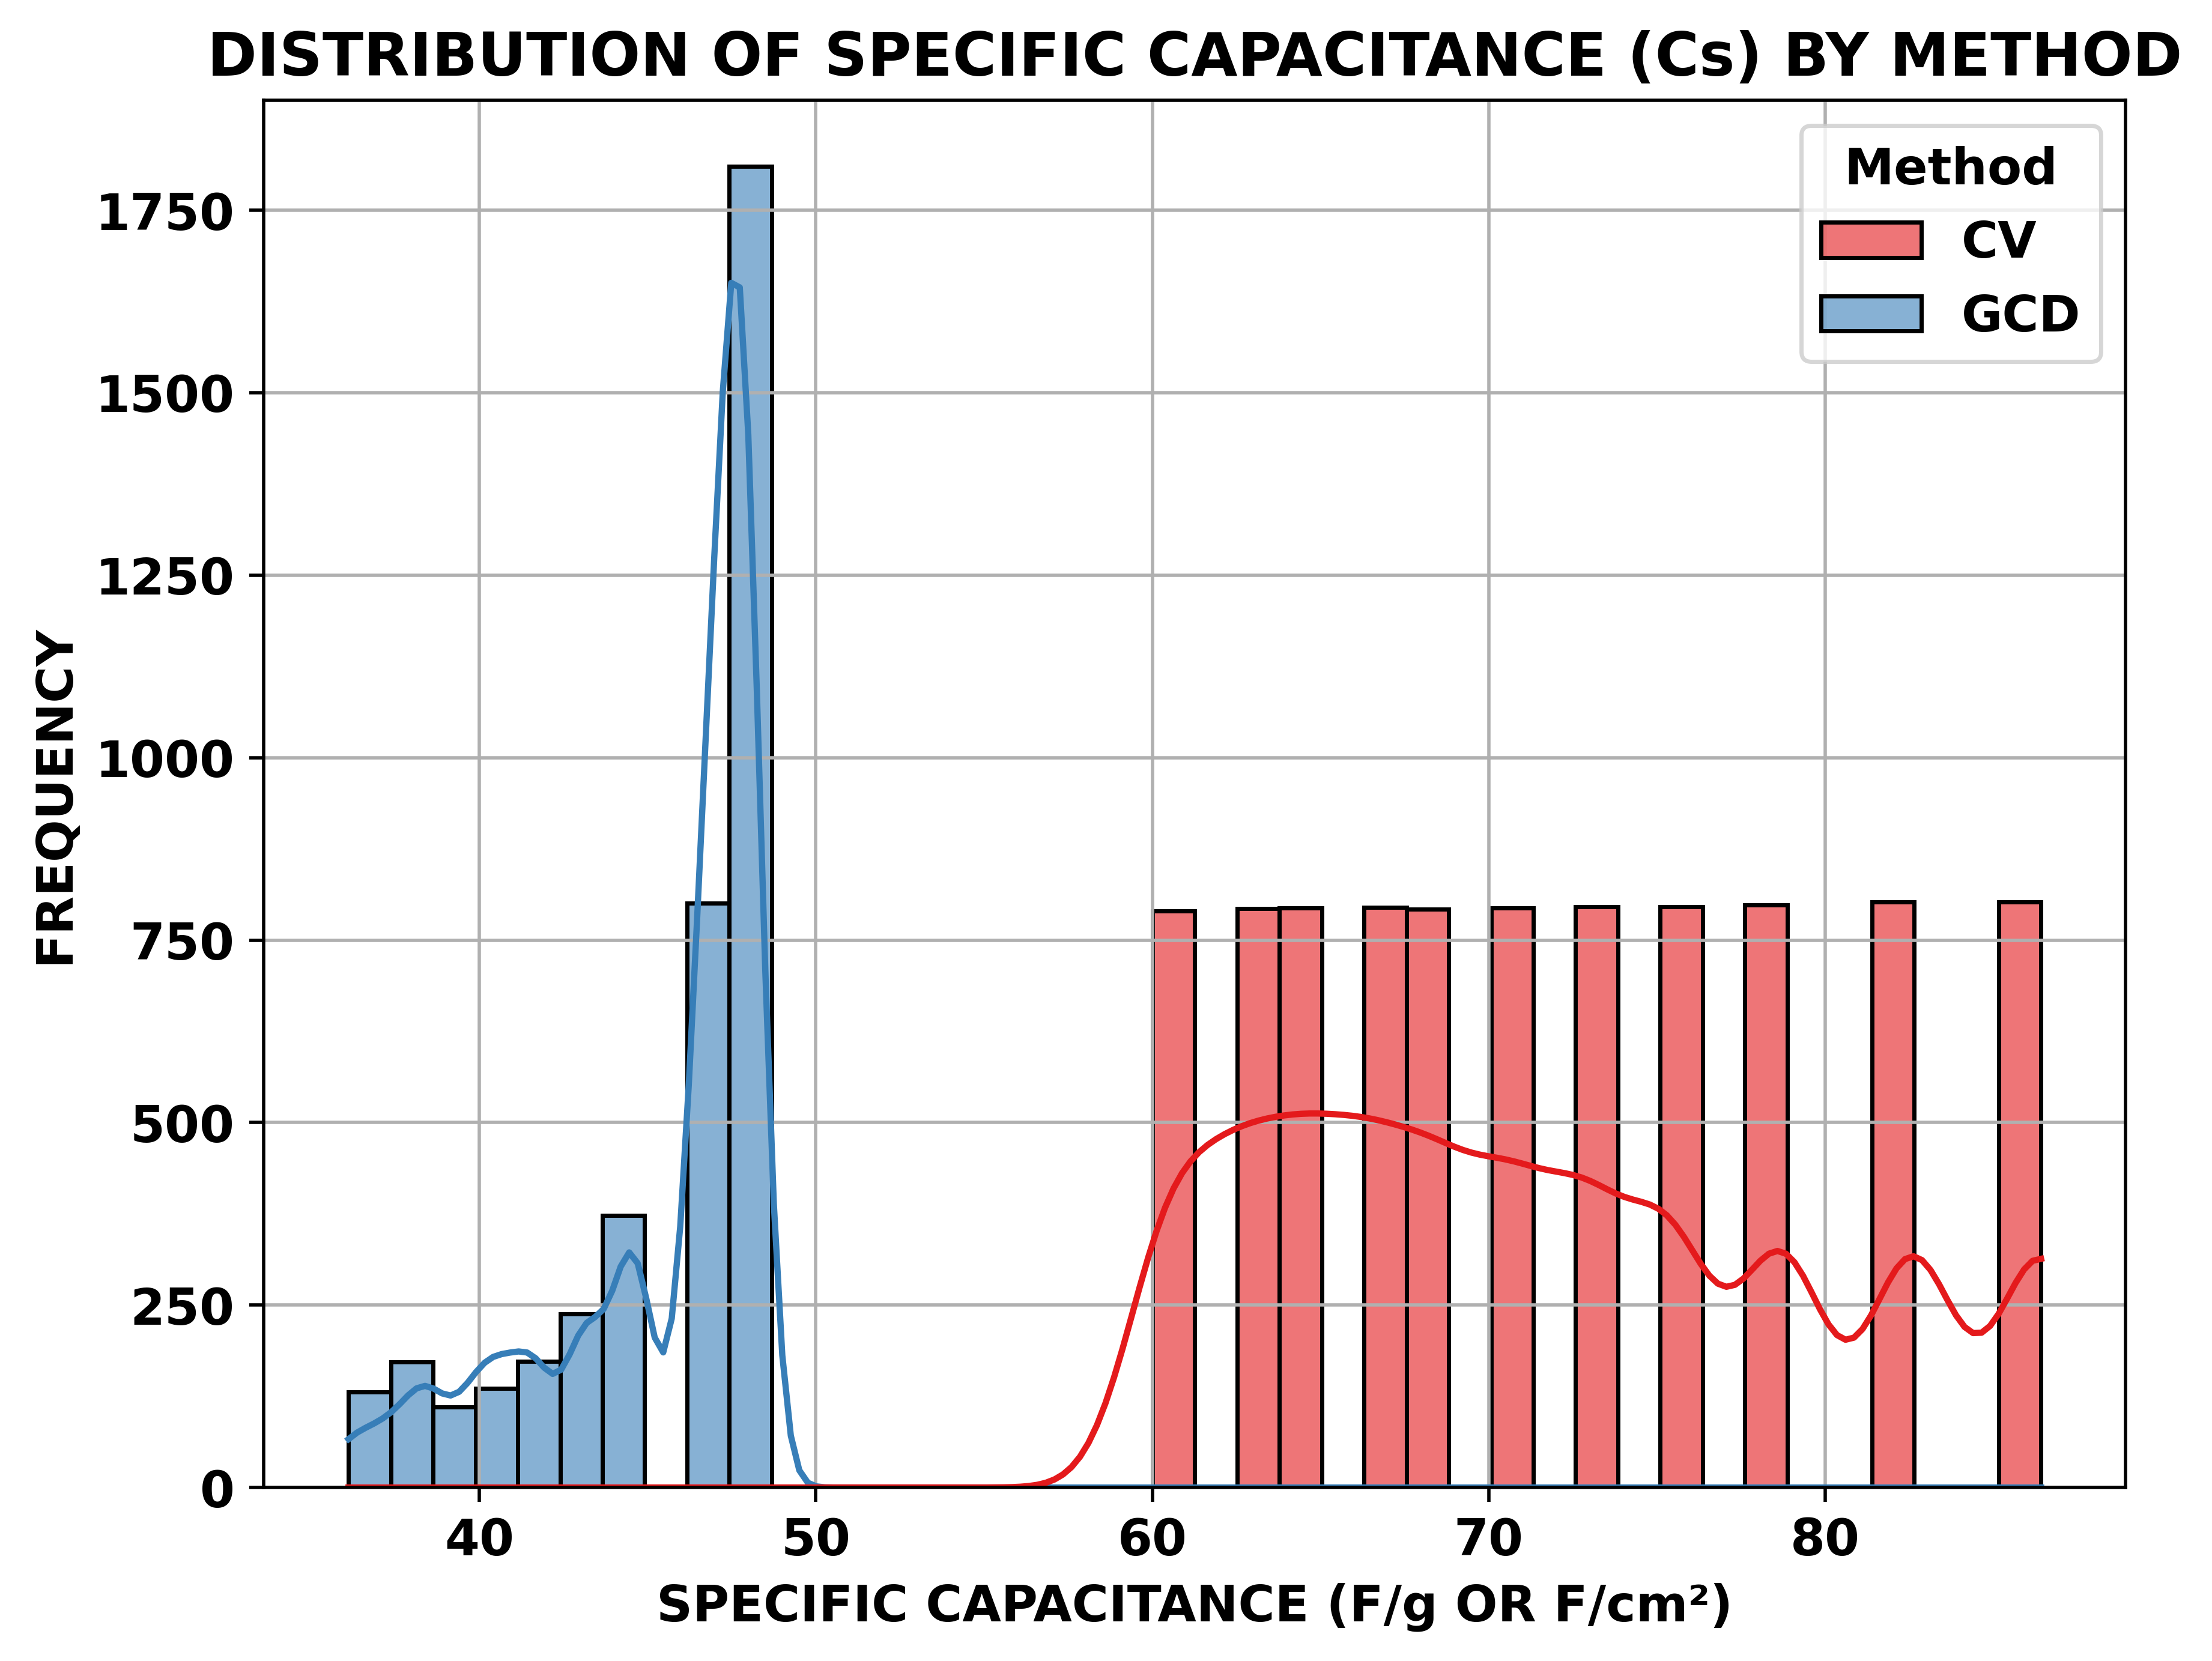

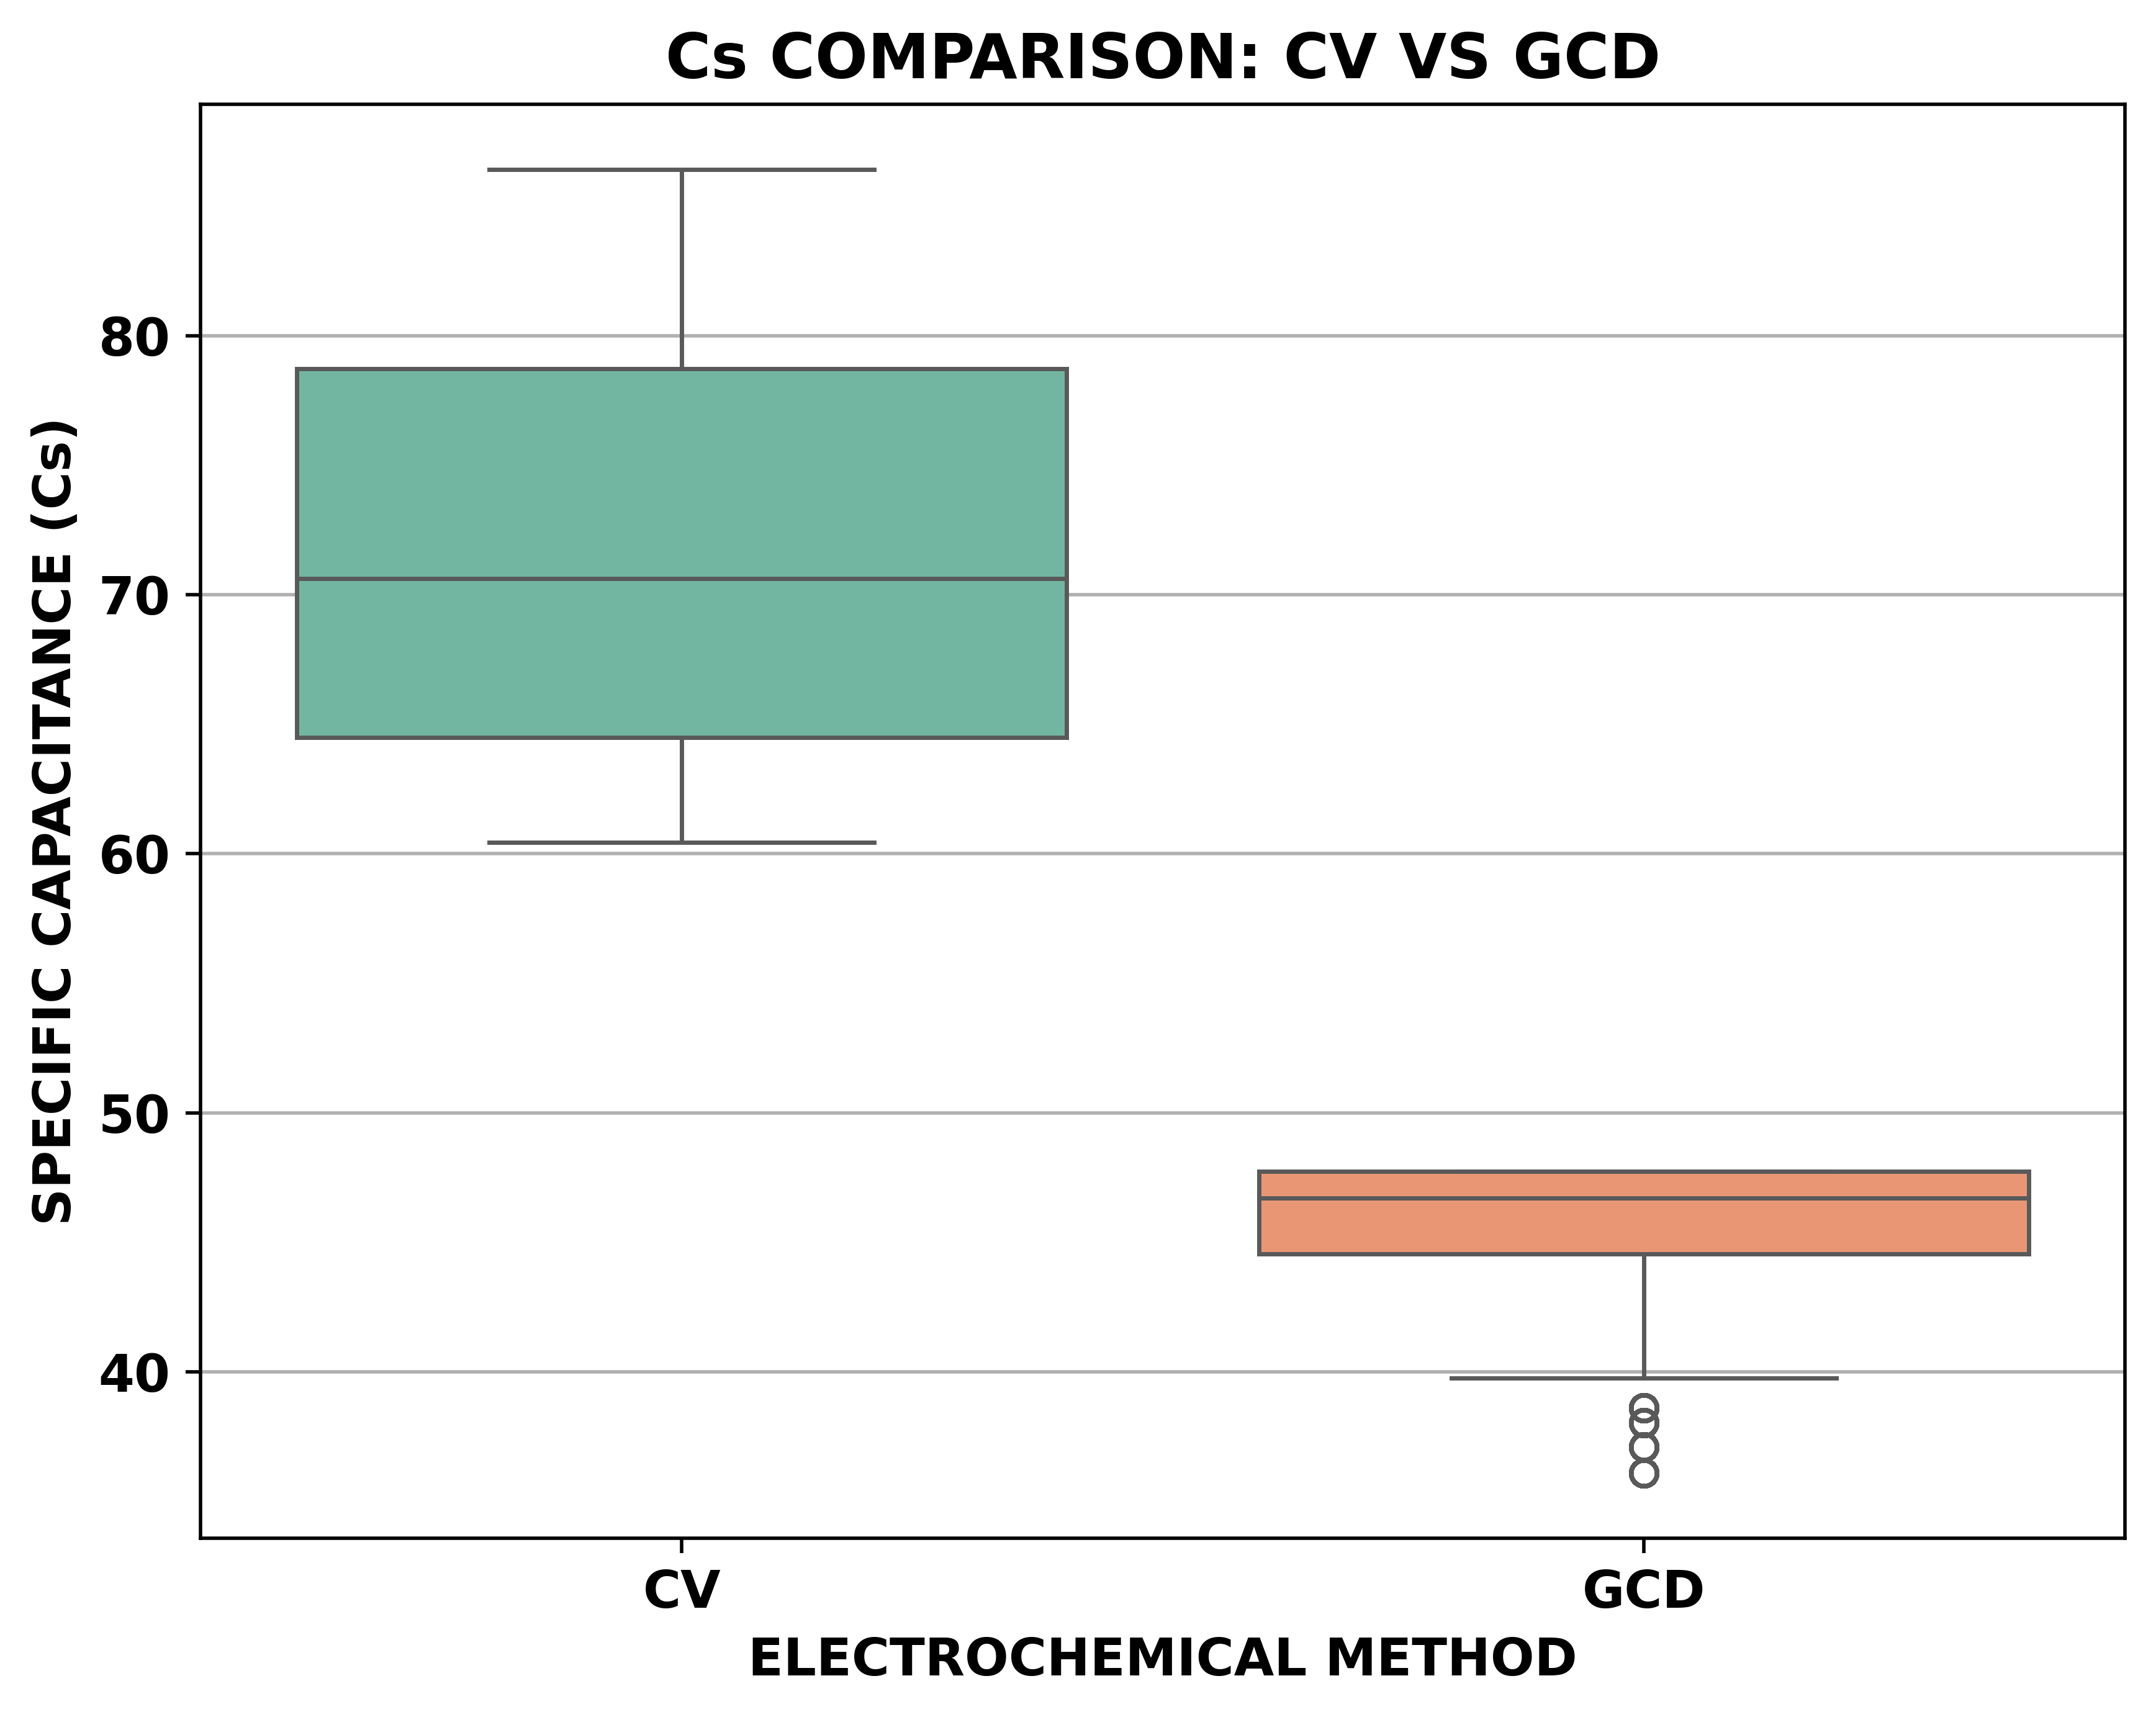

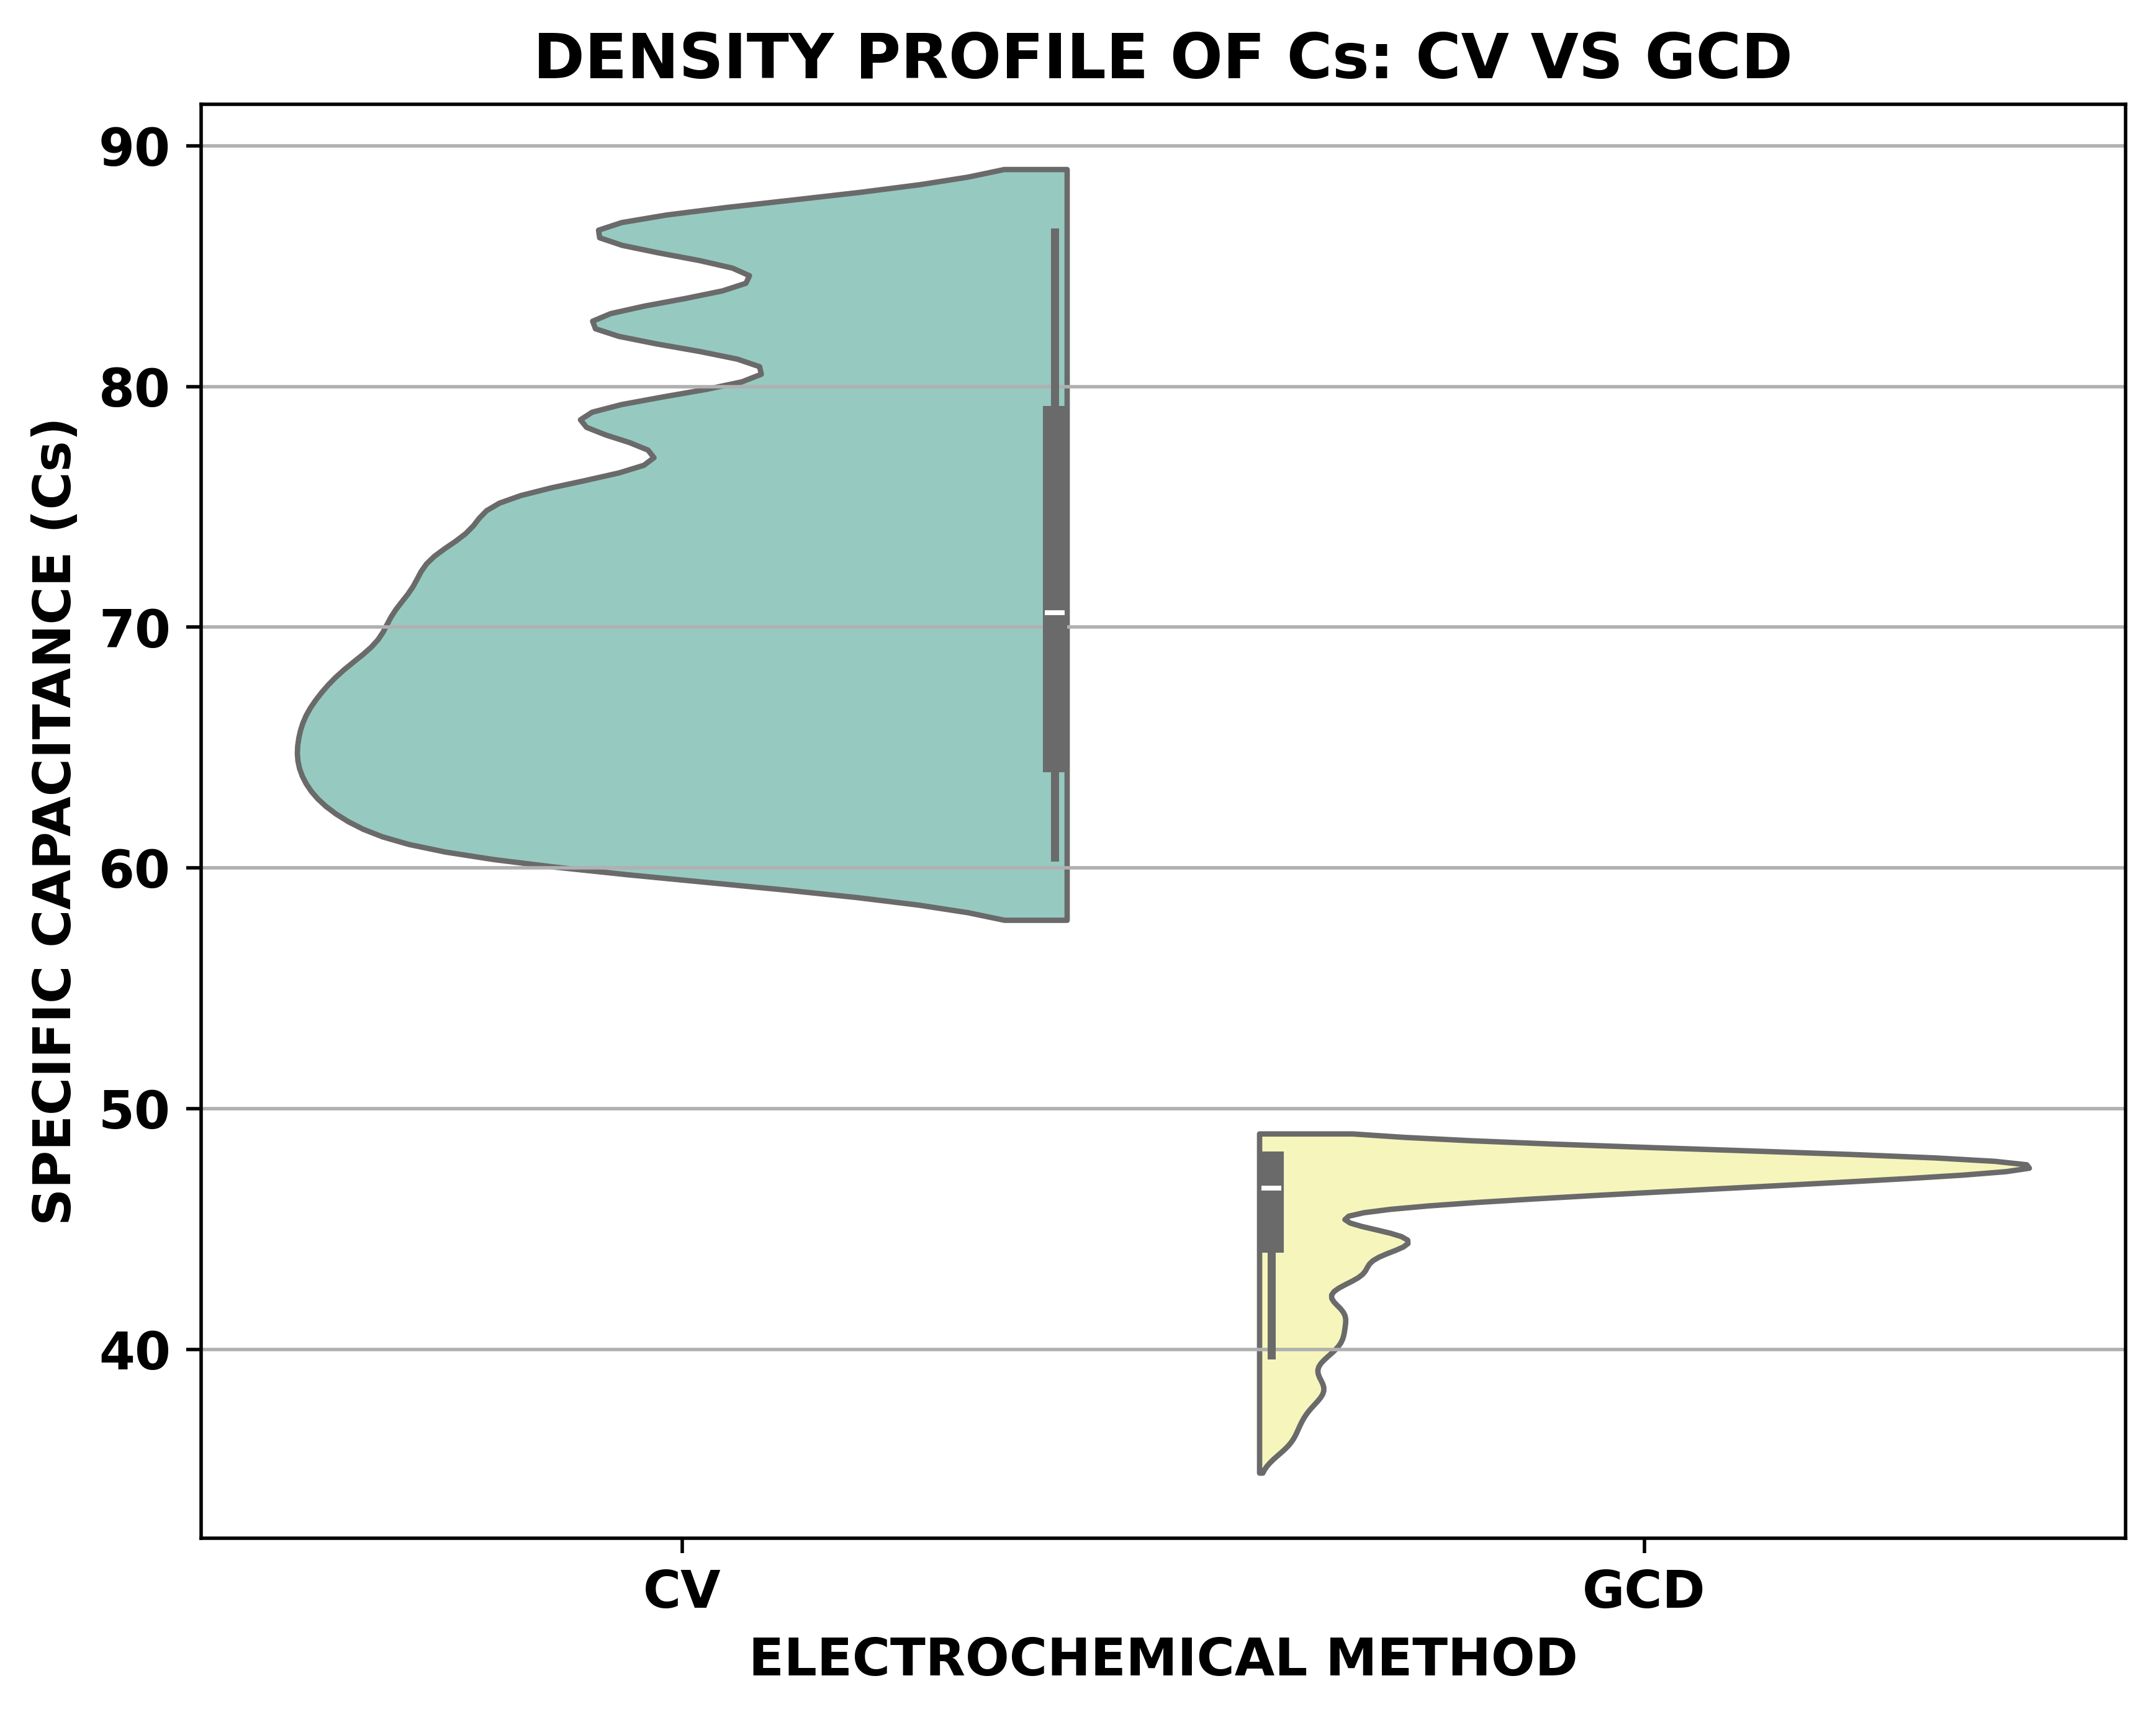

In [ ]:
def plot_cs_distributions(unified_df: pd.DataFrame):
    """
    PLOTS HISTOGRAMS, KDE, AND BOXPLOTS FOR SPECIFIC CAPACITANCE (Cs).
    COMPARES CV VS GCD METHODOLOGIES.
    """
    # 1. HISTOGRAM WITH KDE
    plt.figure()
    sns.histplot(data=unified_df, x='Cs', hue='Method', kde=True, palette='Set1', bins=40, alpha=0.6)
    plt.title('DISTRIBUTION OF SPECIFIC CAPACITANCE (Cs) BY METHOD')
    plt.xlabel('SPECIFIC CAPACITANCE (F/g OR F/cm²)')
    plt.ylabel('FREQUENCY')
    plt.show()

    # 2. BOXPLOT FOR OUTLIERS AND MEDIAN SPREAD
    plt.figure()
    sns.boxplot(data=unified_df, x='Method', y='Cs', palette='Set2')
    plt.title('Cs COMPARISON: CV VS GCD')
    plt.xlabel('ELECTROCHEMICAL METHOD')
    plt.ylabel('SPECIFIC CAPACITANCE (Cs)')
    plt.show()
    
    # 3. VIOLIN PLOT FOR DENSITY BEHAVIOR
    plt.figure()
    sns.violinplot(data=unified_df, x='Method', y='Cs', palette='Set3', split=True)
    plt.title('DENSITY PROFILE OF Cs: CV VS GCD')
    plt.xlabel('ELECTROCHEMICAL METHOD')
    plt.ylabel('SPECIFIC CAPACITANCE (Cs)')
    plt.show()

plot_cs_distributions(unified_df)

### 4.2 ELECTROCHEMICAL VISUALIZATIONS (CV-SPECIFIC)

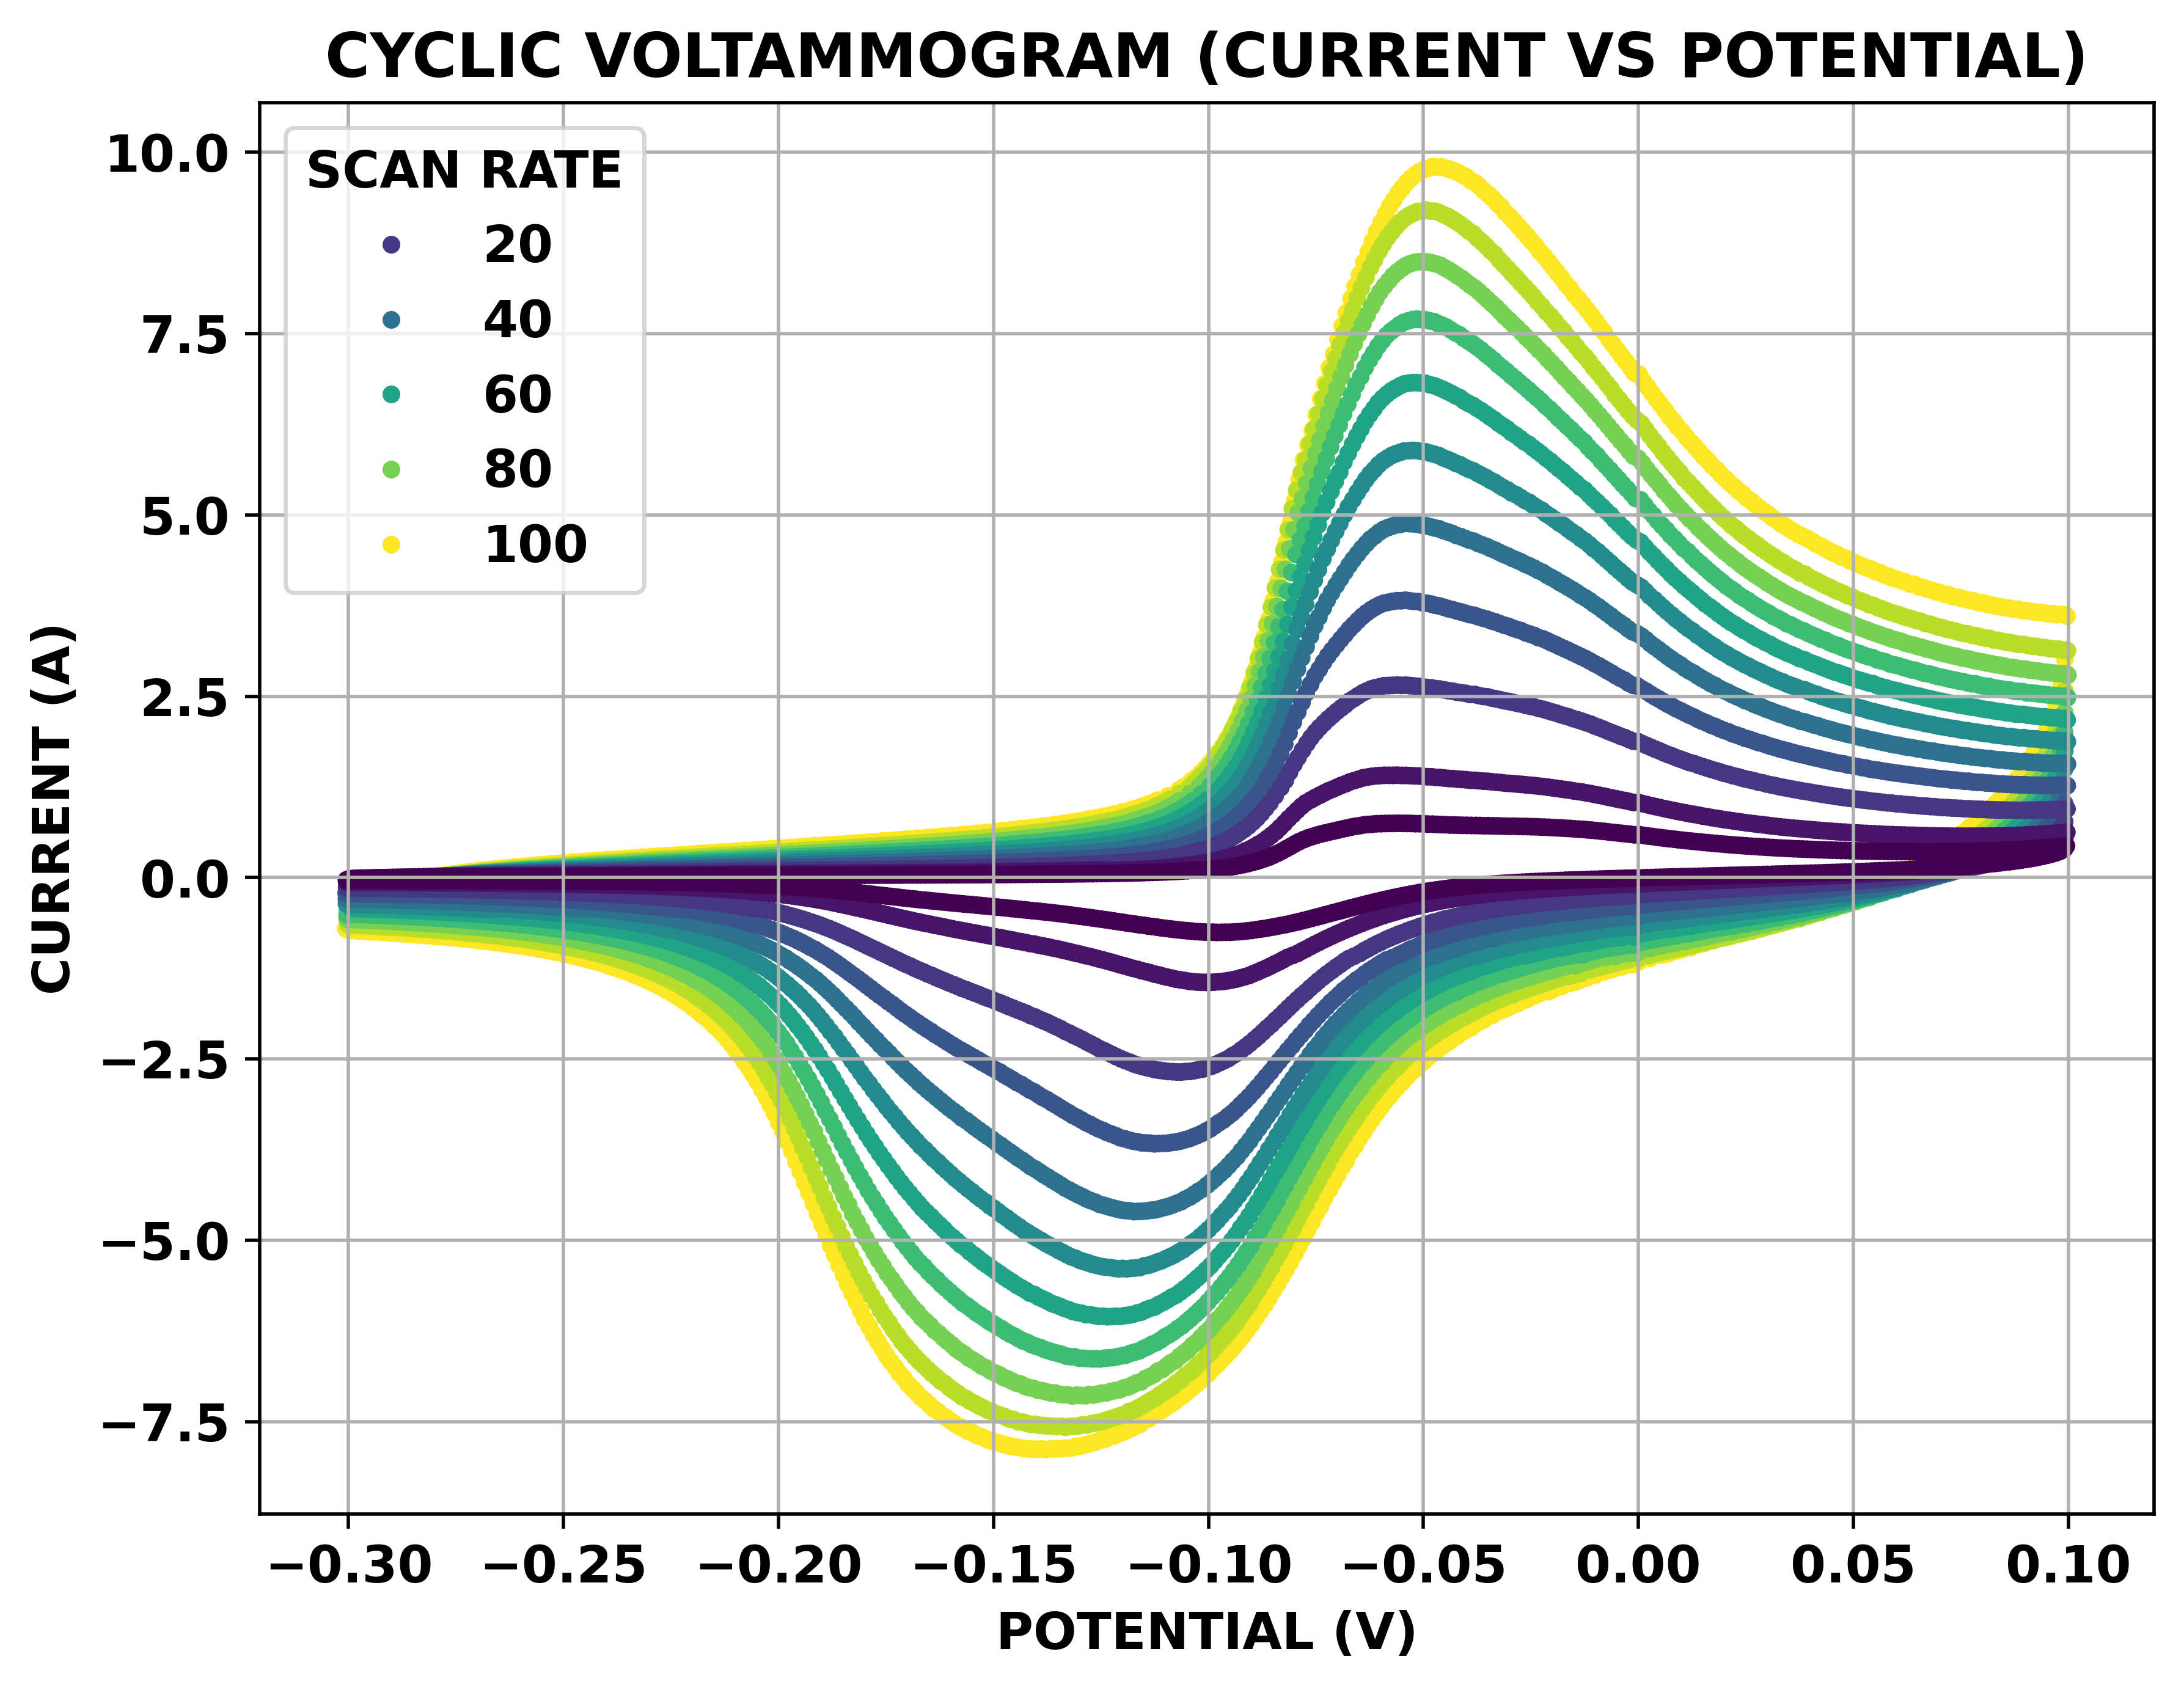

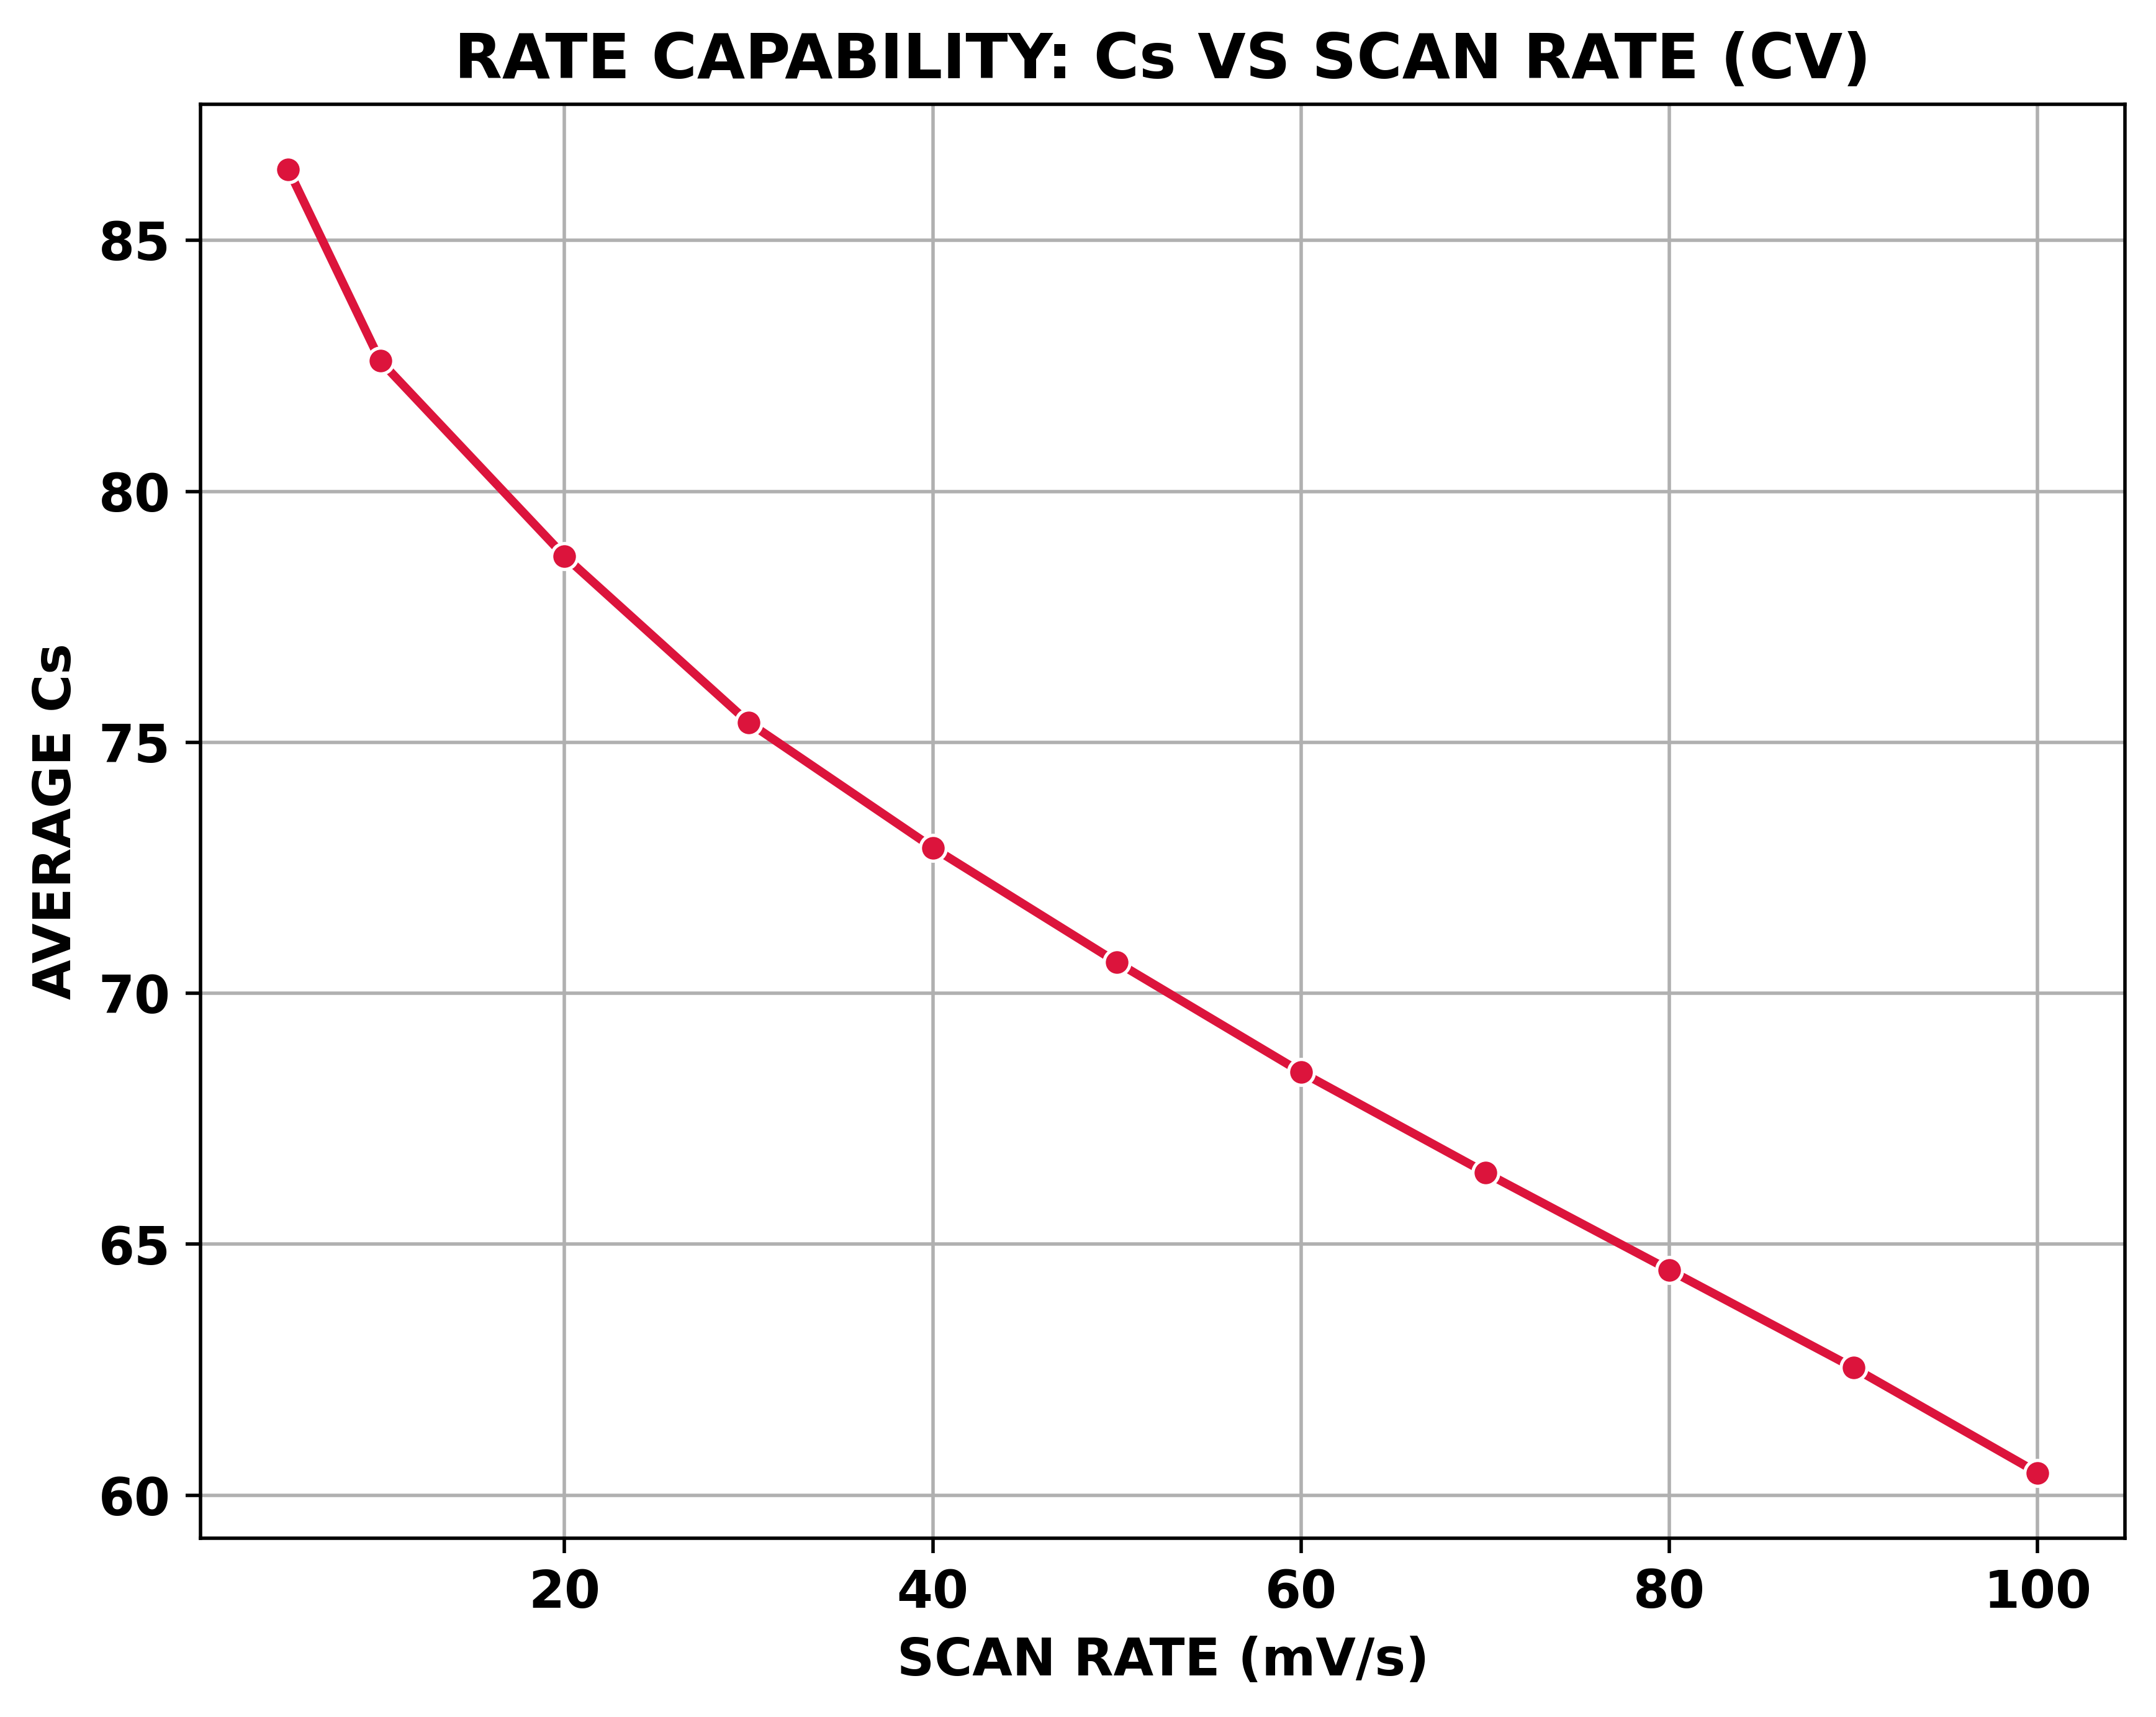

In [ ]:
def plot_cv_electrochemistry(cv_df: pd.DataFrame):
    """
    PLOTS CURRENT VS POTENTIAL (CYCLIC VOLTAMMOGRAMS) AND Cs VS SCAN RATE.
    """
    # 1. CYCLIC VOLTAMMOGRAMS AT VARIOUS SCAN RATES
    plt.figure()
    sns.scatterplot(data=cv_df, x='Potential', y='Current', hue='Scan_Rate', palette='viridis', edgecolor=None, s=15)
    plt.title('CYCLIC VOLTAMMOGRAM (CURRENT VS POTENTIAL)')
    plt.xlabel('POTENTIAL (V)')
    plt.ylabel('CURRENT (A)')
    plt.legend(title='SCAN RATE')
    plt.show()

    # 2. Cs VS SCAN RATE (RATE PERFORMANCE)
    cv_rate = cv_df.groupby('Scan_Rate')['Cs'].mean().reset_index()
    plt.figure()
    sns.lineplot(data=cv_rate, x='Scan_Rate', y='Cs', marker='o', color='crimson', linewidth=2)
    plt.title('RATE CAPABILITY: Cs VS SCAN RATE (CV)')
    plt.xlabel('SCAN RATE (mV/s)')
    plt.ylabel('AVERAGE Cs')
    plt.show()

plot_cv_electrochemistry(cv_clean)

### 4.3 ELECTROCHEMICAL VISUALIZATIONS (GCD-SPECIFIC)

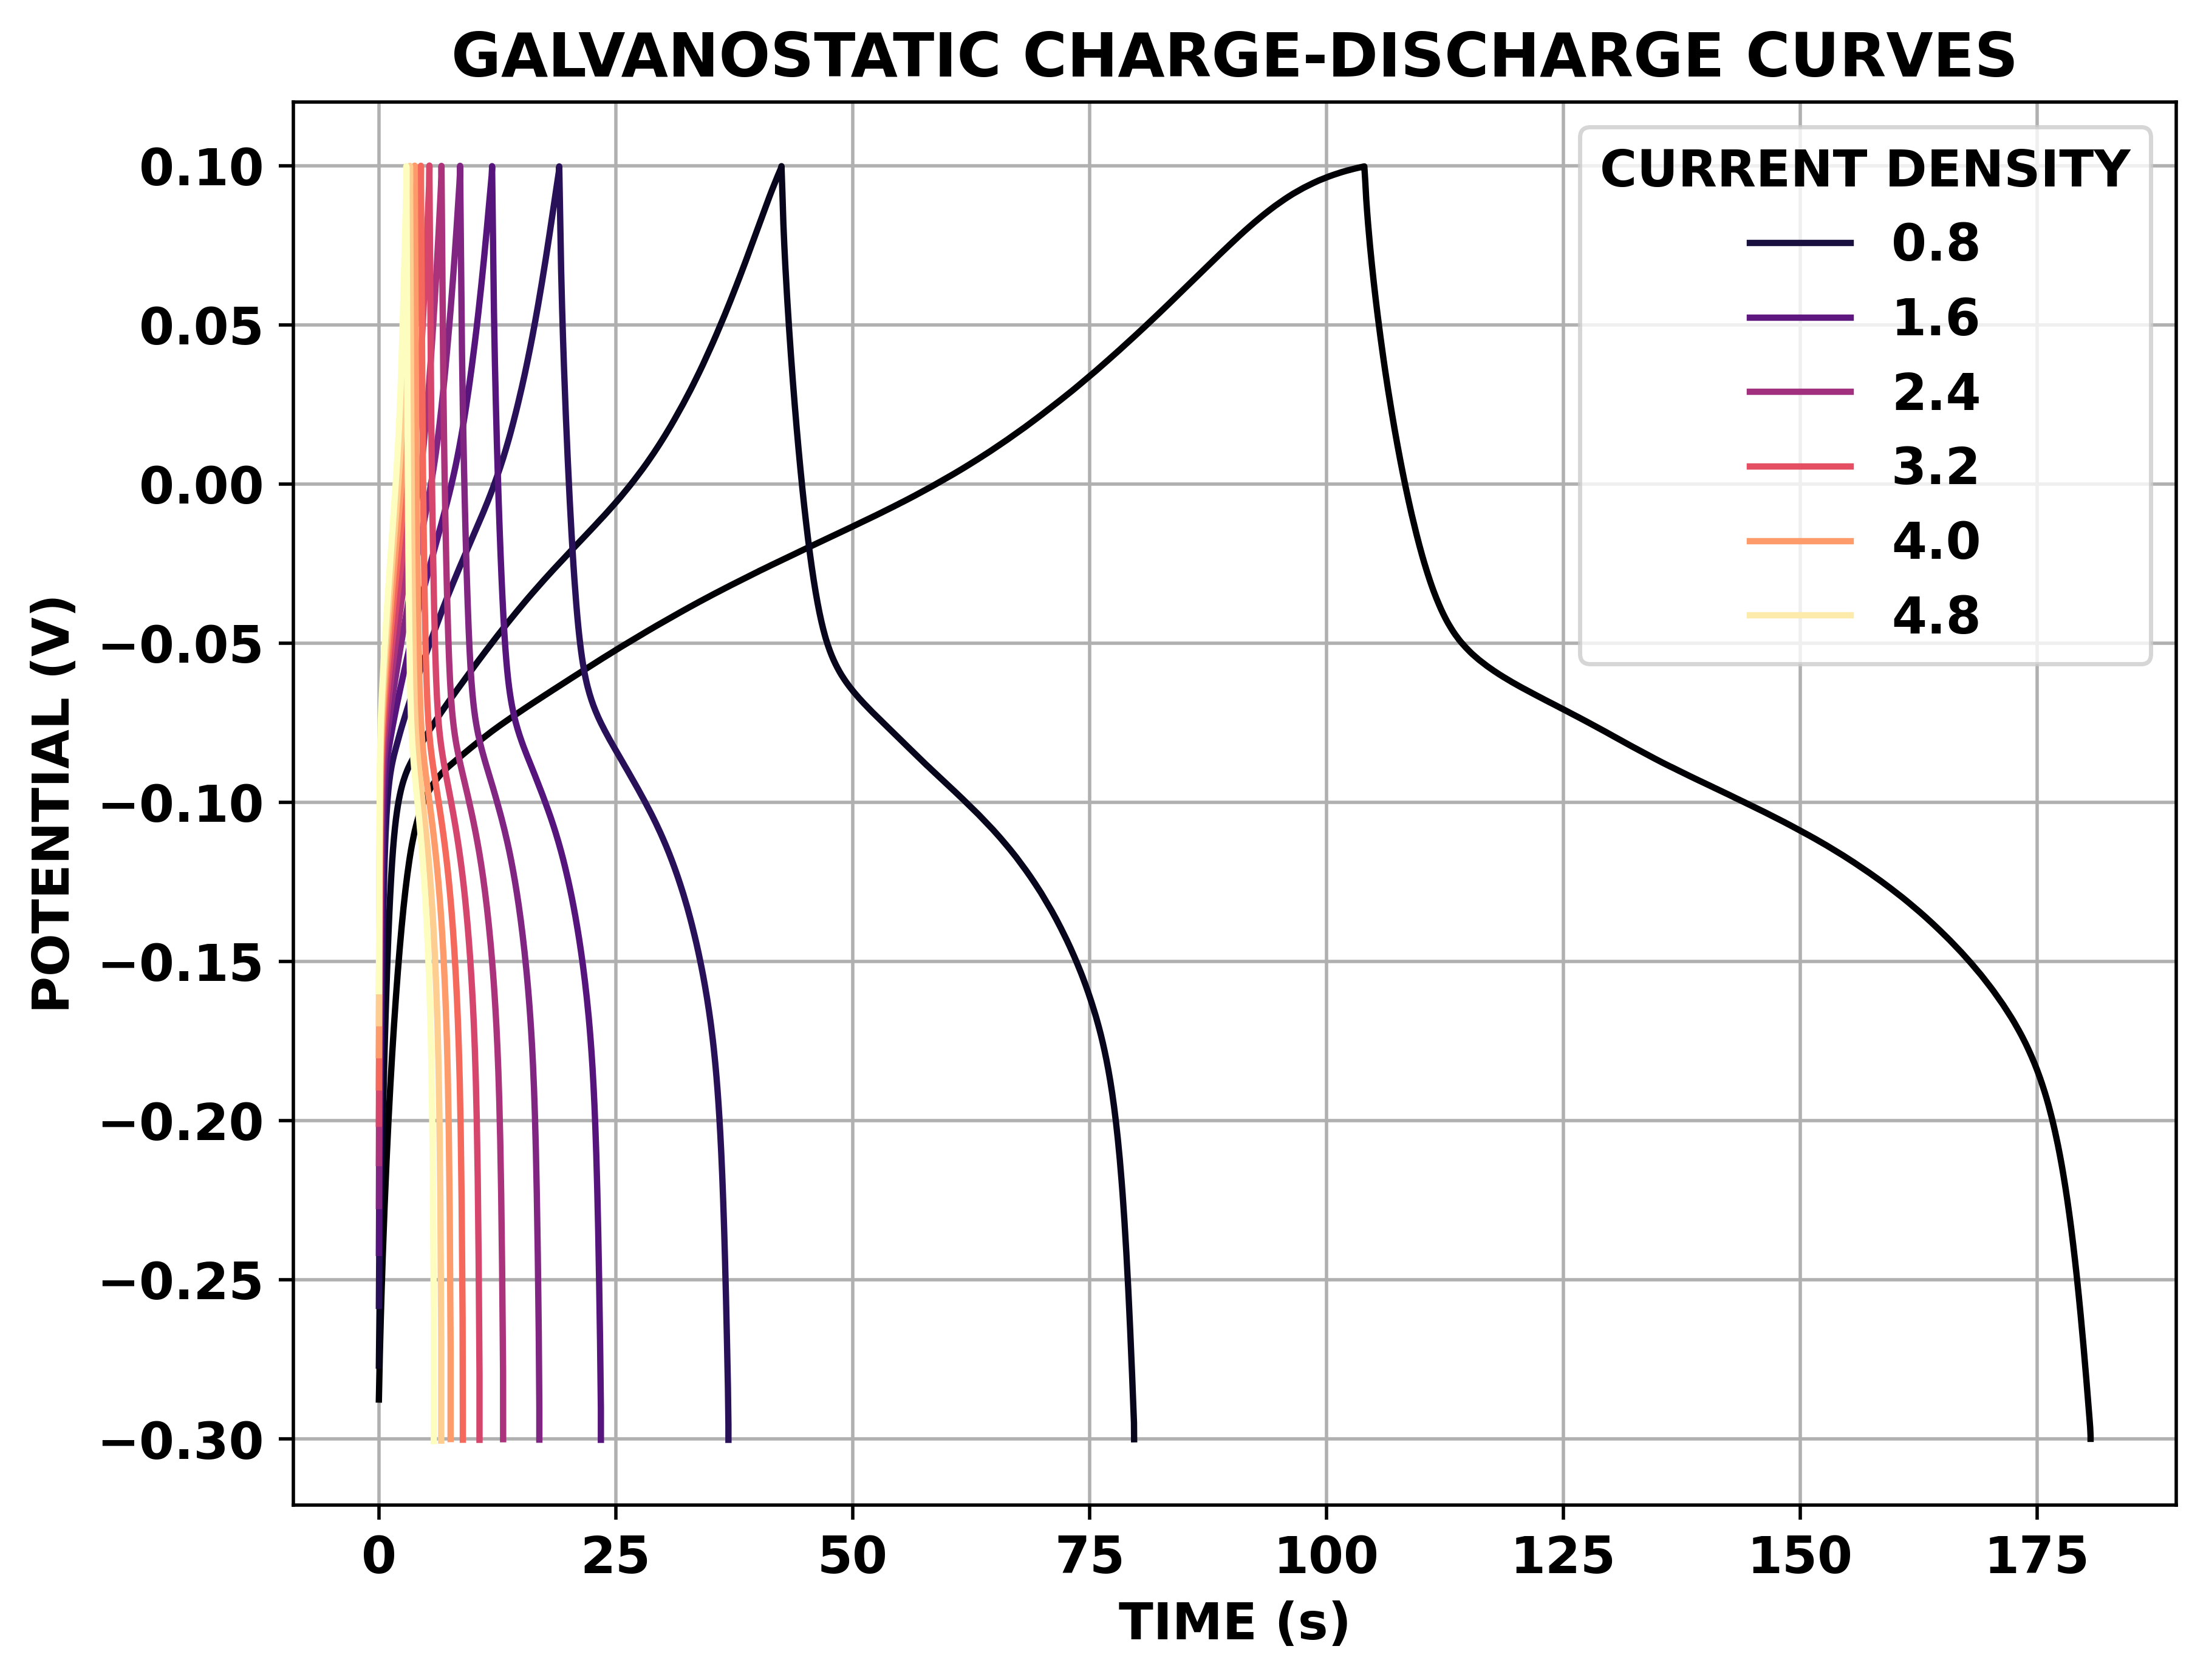

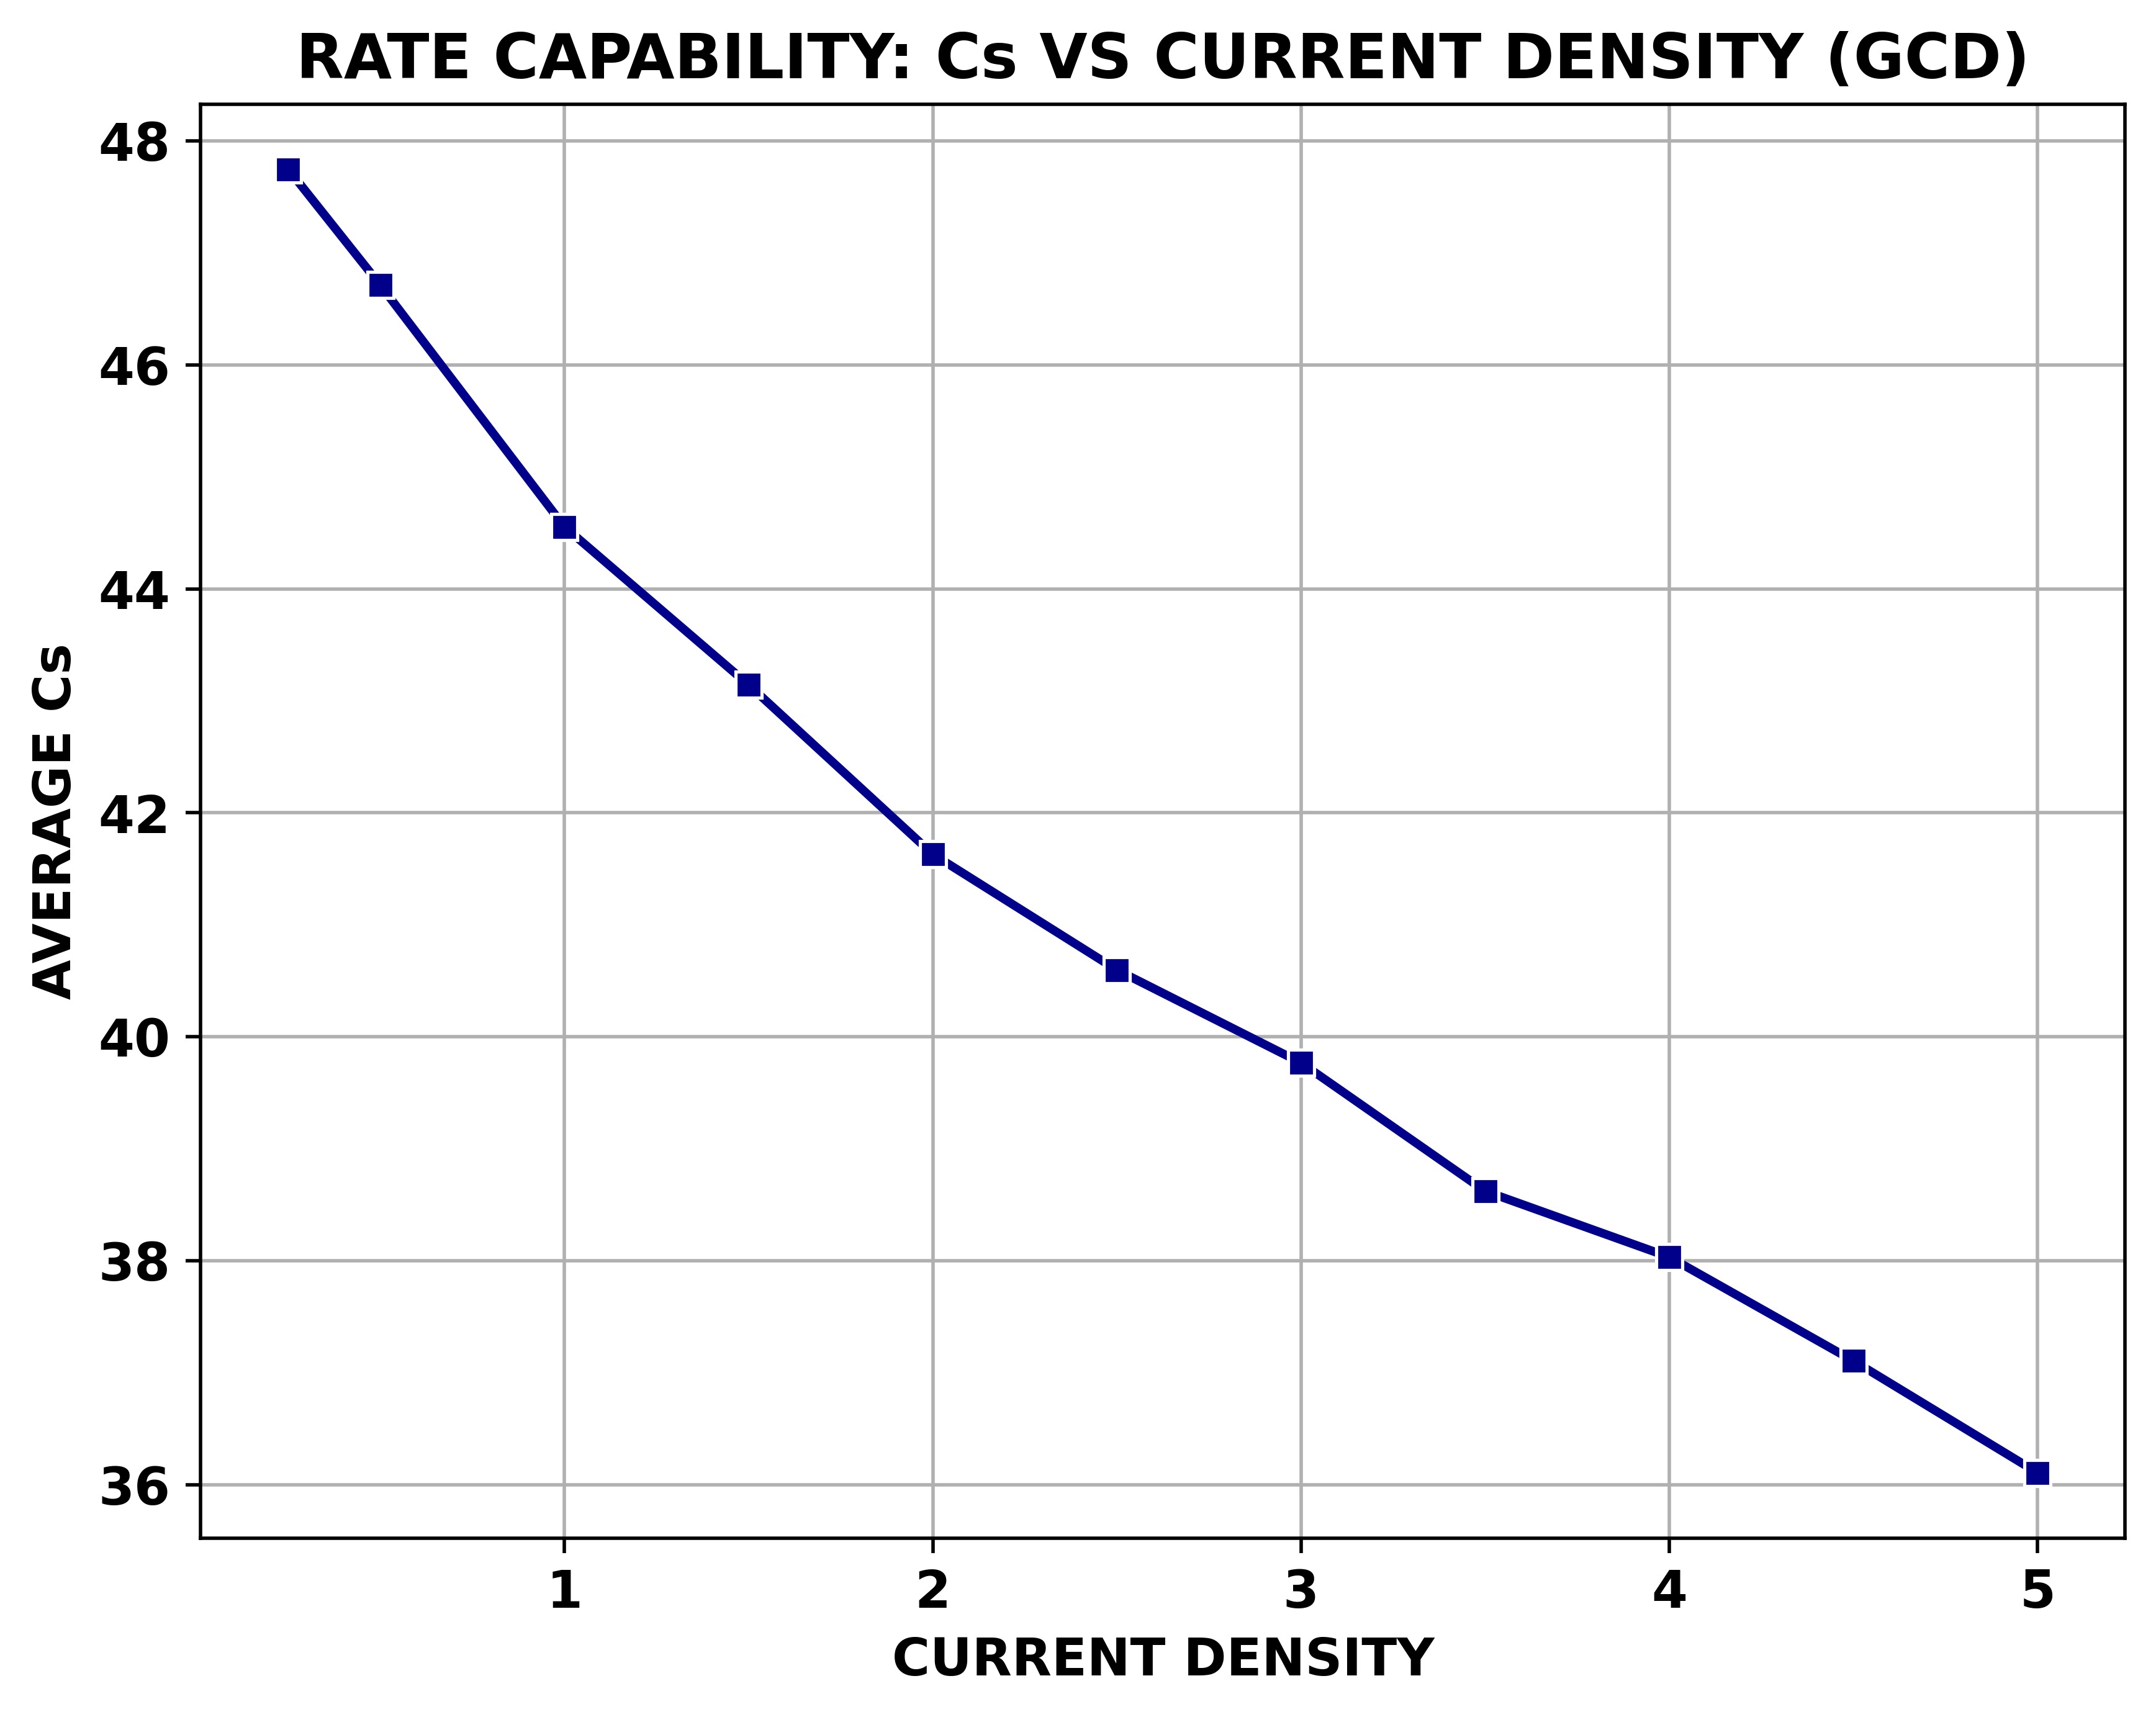

In [ ]:
def plot_gcd_electrochemistry(gcd_df: pd.DataFrame):
    """
    PLOTS VOLTAGE VS TIME (CHARGE-DISCHARGE CURVES) AND Cs VS CURRENT DENSITY.
    """
    # 1. GCD CURVES (VOLTAGE VS TIME)
    plt.figure()
    sns.lineplot(data=gcd_df, x='Time', y='Potential', hue='Current_Density', palette='magma')
    plt.title('GALVANOSTATIC CHARGE-DISCHARGE CURVES')
    plt.xlabel('TIME (s)')
    plt.ylabel('POTENTIAL (V)')
    plt.legend(title='CURRENT DENSITY')
    plt.show()

    # 2. Cs VS CURRENT DENSITY (RATE PERFORMANCE)
    gcd_rate = gcd_df.groupby('Current_Density')['Cs'].mean().reset_index()
    plt.figure()
    sns.lineplot(data=gcd_rate, x='Current_Density', y='Cs', marker='s', color='darkblue', linewidth=2)
    plt.title('RATE CAPABILITY: Cs VS CURRENT DENSITY (GCD)')
    plt.xlabel('CURRENT DENSITY')
    plt.ylabel('AVERAGE Cs')
    plt.show()

plot_gcd_electrochemistry(gcd_clean)

### 4.4 STATISTICAL FEATURE ANALYSIS AND CORRELATION

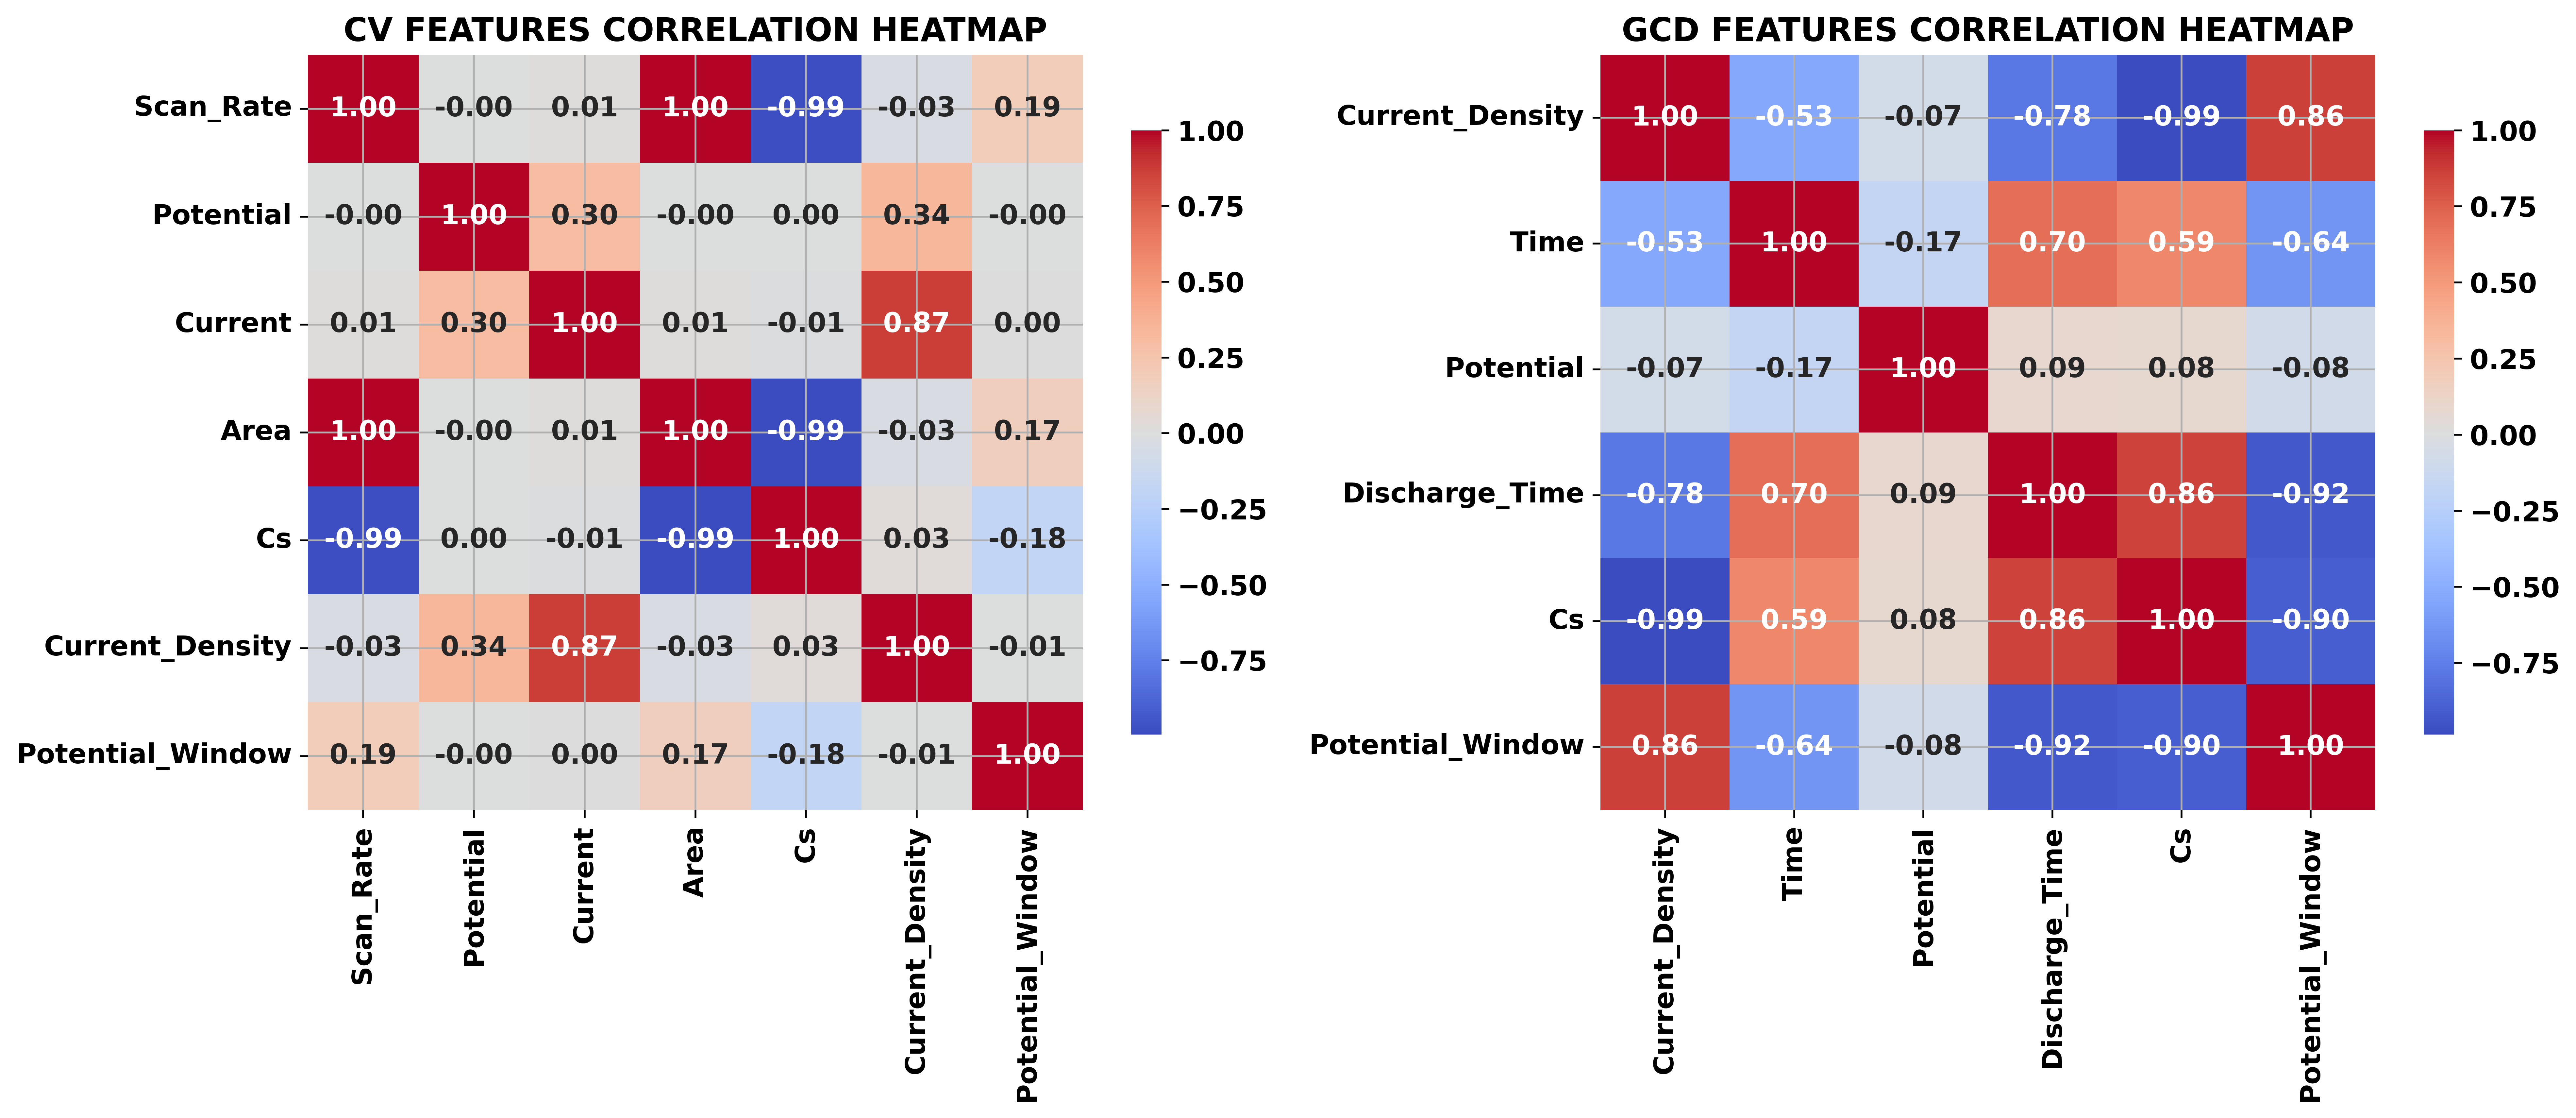

In [ ]:
def plot_correlation_matrices(cv_df: pd.DataFrame, gcd_df: pd.DataFrame):
    """
    PLOTS METHOD-WISE PEARSON CORRELATION HEATMAPS TO IDENTIFY DOMINANT PARAMETERS.
    """
    cv_numeric = cv_df.select_dtypes(include=[np.number])
    gcd_numeric = gcd_df.select_dtypes(include=[np.number])

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # CV HEATMAP
    sns.heatmap(cv_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], cbar_kws={'shrink': .8})
    axes[0].set_title('CV FEATURES CORRELATION HEATMAP')

    # GCD HEATMAP
    sns.heatmap(gcd_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], cbar_kws={'shrink': .8})
    axes[1].set_title('GCD FEATURES CORRELATION HEATMAP')

    plt.tight_layout()
    plt.show()

plot_correlation_matrices(cv_clean, gcd_clean)

# 3. FEATURE ENGINEERING AND MERGING (UPDATED)

### 3.1 CORRECTED FEATURE ENGINEERING

In [12]:
def engineer_features(cv_df: pd.DataFrame, gcd_df: pd.DataFrame) -> pd.DataFrame:
    """
    STANDARDIZES COLUMN NAMES, CREATES METHOD FLAGS, 
    DERIVES NEW ELECTROCHEMICAL FEATURES, AND MERGES BOTH DATASETS.
    
    NOTE: CURRENT IN CV DATASET IS ALREADY THE CURRENT DENSITY.
    """
    # 1. RENAME TARGET AND COMMON COLUMNS
    cv_clean = cv_df.rename(columns={'CS': 'Cs', 'Current': 'Current_Density'})
    gcd_clean = gcd_df.rename(columns={'GCD_CS': 'Cs'})
    
    # 2. METHOD FLAGS
    cv_clean['Method'] = 'CV'
    gcd_clean['Method'] = 'GCD'
    
    # 3. DERIVE POTENTIAL WINDOW FOR CV
    cv_clean['Potential_Window'] = cv_clean.groupby('Scan_Rate')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 4. DERIVE POTENTIAL WINDOW FOR GCD
    gcd_clean['Potential_Window'] = gcd_clean.groupby('Current_Density')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 5. MERGE DATASETS
    # KEEPING DOMAIN-SPECIFIC COLUMNS (PADDED WITH NAN FOR THE OTHER METHOD)
    unified_df = pd.concat([cv_clean, gcd_clean], ignore_index=True)
    
    print(f"=== UNIFIED DATASET SHAPE: {unified_df.shape} ===")
    
    return unified_df, cv_clean, gcd_clean

unified_df, cv_clean, gcd_clean = engineer_features(cv_df, gcd_df)

=== UNIFIED DATASET SHAPE: (12696, 9) ===


In [13]:
unified_df

,Scan_Rate,Potential,Current_Density,Area,Cs,Method,Potential_Window,Time,Discharge_Time
0,100.0,-0.29984,-0.51050,2.41787,60.44685,CV,0.40035,NaN,NaN
1,100.0,-0.29885,-0.41119,2.41787,60.44685,CV,0.40035,NaN,NaN
2,100.0,-0.29786,-0.34692,2.41787,60.44685,CV,0.40035,NaN,NaN
3,100.0,-0.29380,-0.19546,2.41787,60.44685,CV,0.40035,NaN,NaN
4,100.0,-0.29284,-0.17072,2.41787,60.44685,CV,0.40035,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12691,NaN,-0.28868,0.25000,NaN,47.74562,GCD,0.39971,180.3960,76.393
12692,NaN,-0.29243,0.25000,NaN,47.74562,GCD,0.39971,180.4960,76.393
12693,NaN,-0.29627,0.25000,NaN,47.74562,GCD,0.39971,180.5960,76.393
12694,NaN,-0.29904,0.25000,NaN,47.74562,GCD,0.39971,180.6396,76.393


## 3.2 DATA PREPROCESSING ON UNIFIED DATASET

In [14]:
def preprocess_data(unified_df: pd.DataFrame) -> pd.DataFrame:
    """
    HANDLES MISSING VALUES, CHECKS FOR OUTLIERS IN TARGET VARIABLE (Cs),
    AND PREPARES THE CLEANED COMBINED DATASET FOR VISUALIZATION AND MODELING.
    """
    print("=== STARTING PREPROCESSING ===")
    
    # 1. MISSING VALUE ANALYSIS
    print("\nMISSING VALUES PER COLUMN (EXPECTED DUE TO METHOD SPECIFIC FEATURES):")
    print(unified_df.isnull().sum())
    
    # NOTE: WE DO NOT DROP NANS IN 'SCAN_RATE' OR 'TIME' BECAUSE THEY ARE 
    # METHOD-DEPENDENT (CV HAS SCAN_RATE, GCD HAS TIME). WE LEAVE THEM AS IS 
    # FOR EXPLORATORY ANALYSIS AND WILL HANDLE THEM DURING METHOD-SPECIFIC MODELING.
    
    # 2. OUTLIER DETECTION IN Cs (TARGET) USING IQR
    Q1 = unified_df['Cs'].quantile(0.25)
    Q3 = unified_df['Cs'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = unified_df[(unified_df['Cs'] < lower_bound) | (unified_df['Cs'] > upper_bound)]
    print(f"\nDETECTED OUTLIERS IN Cs (IQR METHOD): {len(outliers)}")
    
    if len(outliers) > 0:
        print("OUTLIERS FOUND. DEPENDING ON ELECTROCHEMICAL CONTEXT, THESE MIGHT BE REMOVED.")
        # UNCOMMENT TO DROP OUTLIERS:
        # unified_df = unified_df[~((unified_df['Cs'] < lower_bound) | (unified_df['Cs'] > upper_bound))]
    else:
        print("NO OUTLIERS DETECTED IN Cs. DATA IS CLEAN AND STABLE.")
        
    print(f"\n=== FINAL CLEANED DATASET SHAPE: {unified_df.shape} ===")
    return unified_df

cleaned_unified_df = preprocess_data(unified_df)

=== STARTING PREPROCESSING ===

MISSING VALUES PER COLUMN (EXPECTED DUE TO METHOD SPECIFIC FEATURES):
Scan_Rate           3944
Potential              0
Current_Density        0
Area                3944
Cs                     0
Method                 0
Potential_Window       0
Time                8752
Discharge_Time      8752
dtype: int64

DETECTED OUTLIERS IN Cs (IQR METHOD): 0
NO OUTLIERS DETECTED IN Cs. DATA IS CLEAN AND STABLE.

=== FINAL CLEANED DATASET SHAPE: (12696, 9) ===
